<a href="https://colab.research.google.com/github/Baah134/Baah134/blob/main/SER_CARINE/Paper_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.signal import lfilter
from tqdm import tqdm

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Path to the folder containing p001, p002... p107
DATASET_PATH = "/content/drive/MyDrive/DeepLearning/External/Meta_Ears/"
OUTPUT_PATH = "META_processed_data/"

# The 5 Target Emotions from EmoFormer Paper
TARGET_EMOTIONS = ['adoration', 'anger', 'fear', 'neutral', 'sadness']

# Mapping to Integers
EMOTION_MAP = {
    'adoration': 0,
    'anger': 1,
    'fear': 2,
    'neutral': 3,
    'sadness': 4
}

# [cite_start]EmoFormer Technical Specs [cite: 728, 749, 783]
TARGET_DURATION = 15 # seconds
SAMPLE_RATE = 16000
TOTAL_SAMPLES = TARGET_DURATION * SAMPLE_RATE # 240,000
HOP_LENGTH = 512 # To get ~469 frames from 240k samples
TARGET_FRAMES = 469
N_MFCC = 13

# ==========================================
# 2. FEATURE EXTRACTOR
# ==========================================
def extract_emoformer_features(audio_path):
    """
    Generates the (13, 469, 1) MFCC image required by EmoFormer.
    """
    try:
        # [cite_start]1. Load & Resample [cite: 725]
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # [cite_start]2. Standardization (Pad/Truncate to 15s) [cite: 728]
        if len(y) < TOTAL_SAMPLES:
            # Pad with zeros at the end
            padding = TOTAL_SAMPLES - len(y)
            y = np.pad(y, (0, padding), 'constant')
        else:
            # Truncate
            y = y[:TOTAL_SAMPLES]

        # [cite_start]3. Pre-emphasis Filter [cite: 733]
        # EmoFormer uses alpha=0.97 usually, paper says 0.9 < alpha < 1
        y = lfilter([1, -0.97], [1], y)

        # [cite_start]4. MFCC Extraction [cite: 749]
        # We need output shape (13, 469)
        mfcc = librosa.feature.mfcc(
            y=y,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=2048,
            hop_length=HOP_LENGTH
        )

        # 5. Frame Adjustment (Strict Shape Enforcement)
        # Sometimes librosa gives 470 or 468 depending on centering.
        # We force it to exactly 469.
        if mfcc.shape[1] > TARGET_FRAMES:
            mfcc = mfcc[:, :TARGET_FRAMES]
        elif mfcc.shape[1] < TARGET_FRAMES:
            padding = TARGET_FRAMES - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, padding)), 'constant')

        # [cite_start]6. Final Reshape [cite: 783]
        # Add channel dimension: (13, 469) -> (13, 469, 1)
        # This matches the input for Conv2D
        return mfcc[..., np.newaxis]

    except Exception as e:
        print(f"Error reading {audio_path}: {e}")
        return None

# ==========================================
# 3. MAIN PROCESSING LOOP
# ==========================================
def process_ears_dataset():
    X_list = []
    Y_list = []
    S_list = [] # Speaker IDs (p001, p002...)

    print(f"Scanning EARS dataset at: {DATASET_PATH}")

    if not os.path.exists(DATASET_PATH):
        print("Error: Dataset path does not exist.")
        return

    # Get list of speaker folders (p001 - p107)
    speaker_folders = sorted([f for f in os.listdir(DATASET_PATH) if f.startswith('p') and os.path.isdir(os.path.join(DATASET_PATH, f))])
    print(f"Found {len(speaker_folders)} speaker folders.")

    # Loop through speakers
    total_files = 0

    # Using TQDM on the speakers loop
    for speaker in tqdm(speaker_folders, desc="Processing Speakers"):
        speaker_path = os.path.join(DATASET_PATH, speaker)

        # Get all wav files in this speaker's folder
        files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]

        for file_name in files:
            # Check if file contains one of the 5 target emotions
            # Structure: "emo_adoration_freeform.wav"

            found_emotion = None
            for emo in TARGET_EMOTIONS:
                if emo in file_name:
                    found_emotion = emo
                    break

            # Skip if file is not one of the 5 emotions
            if found_emotion is None:
                continue

            file_path = os.path.join(speaker_path, file_name)

            # Extract
            features = extract_emoformer_features(file_path)

            if features is not None:
                X_list.append(features)
                Y_list.append(EMOTION_MAP[found_emotion]) # 0-4
                S_list.append(speaker) # "p001"
                total_files += 1

    # ==========================================
    # 4. SAVE
    # ==========================================
    print("\nConverting to Numpy Arrays...")
    X = np.array(X_list)
    Y = np.array(Y_list)
    S = np.array(S_list)

    print(f"Total Files Processed: {total_files}")
    print(f"X Shape: {X.shape}") # Should be (N, 13, 469, 1)
    print(f"Y Shape: {Y.shape}")
    print(f"S Shape: {S.shape}")

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    print(f"Saving to {OUTPUT_PATH}...")
    np.save(os.path.join(OUTPUT_PATH, "X_ears.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "Y_ears.npy"), Y)
    np.save(os.path.join(OUTPUT_PATH, "S_ears.npy"), S)
    print("Done.")

if __name__ == "__main__":
    process_ears_dataset()

Scanning EARS dataset at: /content/drive/MyDrive/DeepLearning/External/Meta_Ears/
Found 107 speaker folders.


Processing Speakers: 100%|██████████| 107/107 [14:01<00:00,  7.87s/it]



Converting to Numpy Arrays...
Total Files Processed: 1177
X Shape: (1177, 13, 469, 1)
Y Shape: (1177,)
S Shape: (1177,)
Saving to META_processed_data/...
Done.


In [ ]:
import shutil
import os

# Get the base name of the output folder for the zip file name
# Use rstrip('/') to remove any trailing slash, ensuring os.path.basename works correctly
archive_name = os.path.basename(OUTPUT_PATH.rstrip('/'))
shutil.make_archive(archive_name, 'zip', OUTPUT_PATH)

print(f"Folder '{OUTPUT_PATH}' has been successfully zipped to '{archive_name}.zip'")

In [2]:
import shutil
import os

# Define the name of the zip file to unzip
zip_file_name = "META_processed_data.zip"

# Define the directory where the contents will be extracted
extract_dir = "META_processed_data"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file without printing any messages (suppressed output)
shutil.unpack_archive(zip_file_name, extract_dir, 'zip')

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
DATA_PATH = "META_processed_data/"  # Updated folder name

print("Loading EARS Data...")
if not os.path.exists(DATA_PATH):
    print(f"Error: Path {DATA_PATH} not found.")
else:
    X = np.load(os.path.join(DATA_PATH, "X_ears.npy"))
    Y = np.load(os.path.join(DATA_PATH, "Y_ears.npy"))

    # --- CRITICAL ADDITION: DATA CLEANING ---
    # This ensures no NaN values enter the model, regardless of extraction
    print("Cleaning Data (Filling NaNs with Zeros)...")
    X = np.nan_to_num(X, nan=0.0)

    print(f"Features Shape: {X.shape}")
    print(f"Labels Shape: {Y.shape}")

    # SPLIT STRATEGY: Random 70/30 (For Replication Verification)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.30, random_state=42, stratify=Y
    )

    # Standardization (Fit on Train, Transform Test)
    # 1. Flatten to 2D for scaler
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    print("Standardizing...")
    # 2. Scale and Reshape back to (Batch, 13, 469, 1)
    X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape[0], 13, 469, 1)
    X_test = scaler.transform(X_test_flat).reshape(X_test.shape[0], 13, 469, 1)

# ==========================================
# 2. MODEL ARCHITECTURE (EmoFormer)
# ==========================================
def build_emoformer(input_shape=(13, 469, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # --- PART A: CNN Block (Spatial Features) ---
    # Block 1
    x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Shape becomes (~6, ~234, 16)

    # Block 2
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Shape becomes (~3, ~117, 32)

    # Block 3
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Shape becomes (~1, ~58, 64)

    # Block 4 (No Pooling, just refinement)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- PART B: Reshape for Transformer ---
    # We need a sequence: (Batch, Time_Steps, Features)
    # Current shape is (Batch, 1, 58, 64). We remove the '1' (Frequency dim).
    target_time_steps = x.shape[2] # ~58
    target_features = x.shape[3]   # 64

    x = layers.Reshape((target_time_steps, target_features))(x)

    # Projection (Bridge to Transformer dimensions)
    x = layers.Dense(64, activation='relu')(x)

    # --- PART C: Transformer Encoder ---
    # Layer Norm 1
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)

    # Multi-Head Attention (8 heads, 128 dim as per paper)
    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x_norm, x_norm)
    attn_output = layers.Dropout(0.2)(attn_output)

    # Residual Connection 1
    x = layers.Add()([x, attn_output])

    # Layer Norm 2
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Network
    ffn = layers.Dense(128, activation='relu')(x_norm)
    ffn = layers.Dropout(0.2)(ffn)
    ffn = layers.Dense(64)(ffn) # Project back to embedding dim

    # Residual Connection 2
    x = layers.Add()([x, ffn])

    # --- PART D: Classification Head ---
    # Global Average Pooling over time (Standard for Transformers classification)
    x = layers.GlobalAveragePooling1D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="EmoFormer")

# Build the model
model = build_emoformer(num_classes=5)
model.summary()

# ==========================================
# 3. TRAIN
# ==========================================
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



Loading EARS Data...
Cleaning Data (Filling NaNs with Zeros)...
Features Shape: (1177, 13, 469, 1)
Labels Shape: (1177,)
Standardizing...


Model: "EmoFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 13, 469,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 469,   │        416 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 469,   │         64 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 6, 234,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 234,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 234,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 3, 117,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 3, 117,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 117,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 1, 58, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 58, 64) │     36,928 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 58, 64) │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 58, 64)    │      4,160 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 58, 64)    │        128 │ dense_8[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 58, 64)    │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 58, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 58, 64)    │          0 │ dense_8[0][0],    │
│                     │                   │            │ dropout_7[0][0] 

 Total params: 347,781 (1.33 MB)

 Trainable params: 347,429 (1.33 MB)

 Non-trainable params: 352 (1.38 KB)


Starting Training (Replication Mode)...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 5.2972e-05 - val_accuracy: 0.7316 - val_loss: 1.7511
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 8.2681e-05 - val_accuracy: 0.7345 - val_loss: 1.7534
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 3.2613e-05 - val_accuracy: 0.7345 - val_loss: 1.7565
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 6.3234e-05 - val_accuracy: 0.7345 - val_loss: 1.7607
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.2045e-05 - val_accuracy: 0.7345 - val_loss: 1.7624
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 3.3325e-05 - val_accuracy: 0.7345 - val_loss: 1.7646
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 3.2144e-05 - val_accuracy: 0.7345 - val_loss: 1.7654
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2

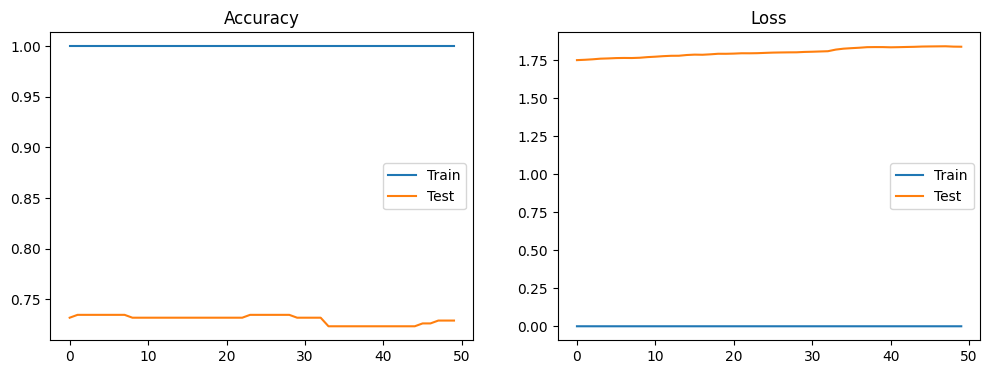

In [9]:
# Callbacks for better training
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

print("\nStarting Training (Replication Mode)...")
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, Y_test),
    #callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==========================================
# 4. RESULTS
# ==========================================
loss, acc = model.evaluate(X_test, Y_test)
print("\n------------------------------------------------")
print(f"REPLICATION RESULT (EARS 5-Emotions)")
print(f"Target Accuracy (Paper): ~90.0%")
print(f"Your Accuracy:           {acc*100:.2f}%")
print("------------------------------------------------")

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.legend()
plt.show()

# **SPEAKER SPLIT**

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. LOAD DATA
# ==========================================
DATA_PATH = "META_processed_data/"

print("Loading EARS Data...")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Path {DATA_PATH} not found. Run extraction first.")

X = np.load(os.path.join(DATA_PATH, "X_ears.npy"))
Y = np.load(os.path.join(DATA_PATH, "Y_ears.npy"))
S = np.load(os.path.join(DATA_PATH, "S_ears.npy")) # Speaker IDs (e.g., 'p001')

# Safety Clean (Just in case)
X = np.nan_to_num(X, nan=0.0)

print(f"Total Samples: {X.shape[0]}")
print(f"Total Speakers: {len(np.unique(S))}")

# ==========================================
# 2. STRICT SPEAKER SPLIT
# ==========================================
# Logic: Train on p001-p104, Test on p105-p107
# Since IDs are strings ('p001', 'p002'...), we can use string comparison.

print("\n--- APPLYING SPEAKER SPLIT ---")
train_mask = S <= 'p104'
test_mask  = S >= 'p105'

X_train, Y_train = X[train_mask], Y[train_mask]
X_test,  Y_test  = X[test_mask],  Y[test_mask]

# Verification
train_speakers = np.unique(S[train_mask])
test_speakers  = np.unique(S[test_mask])

print(f"Training Speakers: {len(train_speakers)} (p001-p104)")
print(f"Testing Speakers:  {len(test_speakers)}  (p105-p107)")
print(f"Train Samples: {X_train.shape[0]}")
print(f"Test Samples:  {X_test.shape[0]}")

# Leakage Check
intersection = np.intersect1d(train_speakers, test_speakers)
if len(intersection) > 0:
    raise ValueError(f"CRITICAL ERROR: Data Leakage! Speakers in both sets: {intersection}")

# ==========================================
# 3. STANDARDIZATION (Prevent Leakage)
# ==========================================
print("\n--- STANDARDIZING ---")
# Fit ONLY on Training Data to simulate "Unseen" test conditions
scaler = StandardScaler()

# Flatten to 2D for scaler
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Fitting scaler on Train set only...")
X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape[0], 13, 469, 1)
X_test  = scaler.transform(X_test_flat).reshape(X_test.shape[0], 13, 469, 1)

# ==========================================
# 4. MODEL ARCHITECTURE (EmoFormer)
# ==========================================
def build_emoformer(input_shape=(13, 469, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # --- CNN Block ---
    x = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- Reshape for Transformer ---
    # Squeeze out the Frequency dim (1) and keep Time (58)
    target_time_steps = x.shape[2]
    target_features = x.shape[3]
    x = layers.Reshape((target_time_steps, target_features))(x)

    x = layers.Dense(64, activation='relu')(x)

    # --- Transformer Encoder ---
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x_norm, x_norm)
    attn_output = layers.Dropout(0.2)(attn_output)
    x = layers.Add()([x, attn_output])

    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn = layers.Dense(128, activation='relu')(x_norm)
    ffn = layers.Dropout(0.2)(ffn)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])

    # --- Output ---
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="EmoFormer_SpeakerSplit")

model = build_emoformer(num_classes=5)
model.summary()

# ==========================================
# 5. TRAIN
# ==========================================
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)



Loading EARS Data...
Total Samples: 1177
Total Speakers: 107

--- APPLYING SPEAKER SPLIT ---
Training Speakers: 104 (p001-p104)
Testing Speakers:  3  (p105-p107)
Train Samples: 1144
Test Samples:  33

--- STANDARDIZING ---
Fitting scaler on Train set only...


Model: "EmoFormer_SpeakerSplit"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 469,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 469,   │        416 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 469,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 234,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 234,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 234,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 117,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 117,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 117,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 58, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 58, 64) │     36,928 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 58, 64) │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 58, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 58, 64)    │      4,160 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 58, 64)    │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 58, 64)    │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 58, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 58, 64)    │          0 │ dense[0][0],      │
│                     │                   │            │ dropout_1[0][0] 

 Total params: 347,781 (1.33 MB)

 Trainable params: 347,429 (1.33 MB)

 Non-trainable params: 352 (1.38 KB)

In [6]:
print("\n--- SPEAKER SPLIT VERIFICATION ---")
print(f"Unique Training Speakers (first 5): {train_speakers[:5]} ... (last 5): {train_speakers[-5:]}")
print(f"Unique Testing Speakers: {test_speakers}")

if len(intersection) == 0:
    print("Result: No speaker overlap found between training and testing sets. Split successful!")
else:
    print(f"Warning: {len(intersection)} speakers found in both train and test sets: {intersection}")

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")


--- SPEAKER SPLIT VERIFICATION ---
Unique Training Speakers (first 5): ['p001' 'p002' 'p003' 'p004' 'p005'] ... (last 5): ['p100' 'p101' 'p102' 'p103' 'p104']
Unique Testing Speakers: ['p105' 'p106' 'p107']
Result: No speaker overlap found between training and testing sets. Split successful!
Number of training samples: 1144
Number of testing samples: 33



Starting Training (Strict Speaker Split)...
Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 736ms/step - accuracy: 0.3797 - loss: 1.4355 - val_accuracy: 0.2121 - val_loss: 2.8858
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5987 - loss: 0.9724 - val_accuracy: 0.2121 - val_loss: 3.9731
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7303 - loss: 0.7255 - val_accuracy: 0.1818 - val_loss: 8.7716
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7862 - loss: 0.5348 - val_accuracy: 0.1818 - val_loss: 8.4186
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8948 - loss: 0.3025 - val_accuracy: 0.1818 - val_loss: 9.6652
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9159 - loss: 0.2268 - val_accuracy: 0.1818 - val_loss: 8.4387
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9666 - loss: 0.1114 - val_accuracy: 0.2727 - val_loss: 7.7670
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0

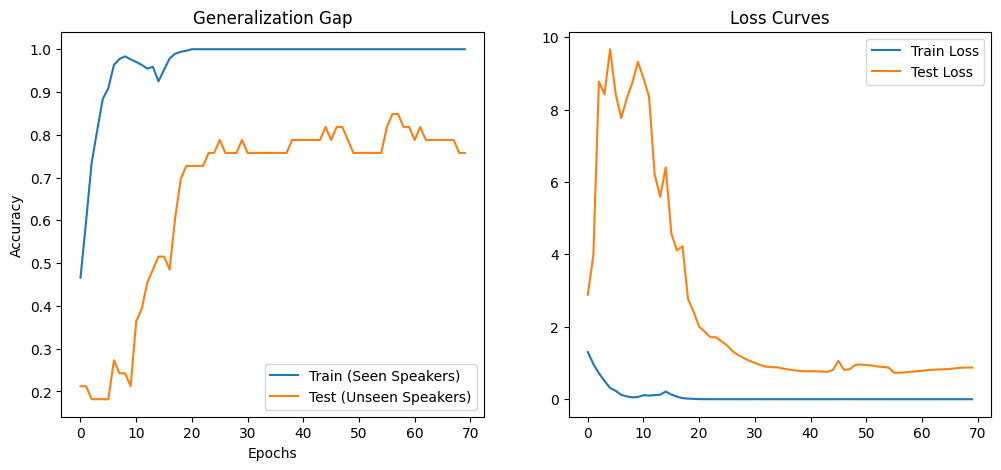

In [5]:
print("\nStarting Training (Strict Speaker Split)...")
history = model.fit(
    X_train, Y_train,
    epochs=70,
    batch_size=64,
    validation_data=(X_test, Y_test), # Explicitly testing on Unseen Speakers
    #callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==========================================
# 6. EVALUATION
# ==========================================
loss, acc = model.evaluate(X_test, Y_test)
print("\n================================================")
print(f"RESULTS: SPEAKER GENERALIZATION TEST")
print("================================================")
print(f"Replication Accuracy (Random Split): ~90.0%")
print(f"Strict Split Accuracy (Unseen Spkrs): {acc*100:.2f}%")
print("================================================")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train (Seen Speakers)')
plt.plot(history.history['val_accuracy'], label='Test (Unseen Speakers)')
plt.title('Generalization Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

**The paper achieved 90% train accuracy when they used combined speakers and 73% validation; however, when you do speaker split, validation is just stuck at 76%. Model is worth investigation**